In [ ]:
#Steven Zajac-Descoteaux

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
import sklearn.cluster as cl

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [3]:
from sklearn.metrics import fowlkes_mallows_score,accuracy_score,confusion_matrix,classification_report

In [4]:
load_digits().keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
#df = pd.DataFrame(data=load_digits()['data'],columns=load_digits()['feature_names'])

In [6]:
#print(load_digits()['DESCR'])

In [7]:
digits = load_digits()

In [8]:
N_CLUSTERS = 10 
X = digits.data
kmeans = KMeans(n_clusters=N_CLUSTERS,random_state=0)
kmeans.fit(X)
centers = kmeans.cluster_centers_.reshape(10,8,8)#RESHAPE as above

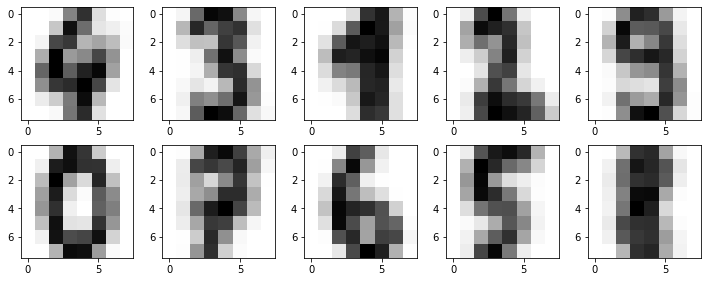

In [9]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(10,4))
k = 0

for r in range(2):
    for c in range(5):
        
        ax[r,c].imshow(centers[k],cmap=plt.cm.gray_r,interpolation='nearest',)
        k += 1
        
plt.tight_layout()

In [10]:
#2 
from statistics import mode

pred = kmeans.predict(X)

label = np.zeros_like(pred) #Same shape as pred

for i in range(0,10):
    label[pred==i] = mode(digits.target[pred==i])

In [11]:
#3
accuracy_score(digits.target,label)

0.7952142459654981

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,  55,  24,   1,   0,   1,   2,   0,  99,   0],
       [  1,   2, 148,  13,   0,   0,   0,   3,   8,   2],
       [  0,   0,   1, 155,   0,   2,   0,   7,   7,  11],
       [  0,   7,   0,   0, 163,   0,   0,   7,   4,   0],
       [  0,   0,   0,   1,   2, 136,   1,   0,   0,  42],
       [  1,   1,   0,   0,   0,   0, 177,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0, 177,   2,   0],
       [  0,   6,   3,   4,   0,   4,   2,   5, 102,  48],
       [  0,  20,   0,   6,   0,   6,   0,   7,   2, 139]])

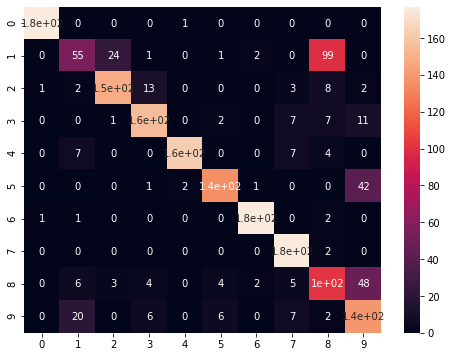

In [12]:
plt.subplots(figsize=(8,6))

sns.heatmap(confusion_matrix(digits.target,label),annot=True)
confusion_matrix(digits.target,label)

In [27]:
print(classification_report(digits.target,label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.60      0.30      0.40       182
           2       0.84      0.84      0.84       177
           3       0.86      0.85      0.85       183
           4       0.98      0.90      0.94       181
           5       0.91      0.75      0.82       182
           6       0.97      0.98      0.98       181
           7       0.86      0.99      0.92       179
           8       0.45      0.59      0.51       174
           9       0.57      0.77      0.66       180

    accuracy                           0.80      1797
   macro avg       0.80      0.80      0.79      1797
weighted avg       0.81      0.80      0.79      1797



### INTERPRETATION

* The accuracy score metric returns a value between 0.0 and 1.0 with 1.0 being a perfect score. With an accuracy score of 0.7952, that is a pretty good score for the clustering model. Some of the issues that arose which impacted the accuracy score can be better understood by looking at the confusion matrix. This clustering model definitely had more of a hard time with certain numbers than with other. Overall 8 out of ten numbers on average would be correctly predicted which still means that 20% of numbers would be missed. 

* A confusion matrix allows us to visualize the true values and the predicted values for the digits. This allows us to see which numbers the model has the most difficult time distinguishing. As we can see the number 1 had more false positives than true positives. The number 5 and 8 also high more false positives than the the rest of the numbers.

In [14]:
#4
fowlkes_mallows_score(digits.target,label)

0.7041643183491655

### INTERPRETATION:

* The Fowlkes Mallows Score provides the geometric mean between precision and recall. Like Accuracy Score, the Fowlkes Mallows Score fits between 0 and 1, and a higher score indicates a good similarity between two clusters. It gets this score by taking the number of True Positives and dividing it by the square root of the sum of the True Positives and False Positives, multiplied by the sum of the True Positives and False Negatives. That being said, a FMI (Fowlkes Mallows index) of .7042 which indicates that there is a good similarity between the model and observed data

* To get the FMI, you take the square root of the precision and recall scores. Precision looks at the ratio of True Positives divided by the sum of True Positives and False Positives. Recall looks at the ratio of True Positives divided by the sum of True Positives and False Negatives. On the other hand Accuracy is the ratio of the sum of True Positives and True Negatives over the sum of all True and False Negatives and Poisitives. That being said, to get the totals of True and False Positives & Negatives, you can refer to the confusion matrix. 

* In the end the accuracy score tellus us that .7952 of the data was classified correctly while the FMI determins the similarity between two clusters of data. In this case, .7042

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

(273280, 3)

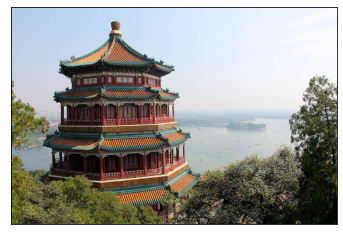

In [15]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")

ax = plt.axes(xticks=[],yticks=[])
ax.imshow(china);

#One way we can see the set of pixels as a cloud of points is to reshape the data into:
#[n_samples * n_features] and rescale the colours so they are between 0 and 1

data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

In [16]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
#https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/ #Shorter code

#Inertia: It is the sum of squared distances of samples to their closest cluster center.
#Distortion: It is calculated as the average of the squared distances from the cluster centers of
# the respective clusters. Typically, the Euclidean distance metric is used.

import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues...
from sklearn.cluster import MiniBatchKMeans

inertias = []
K = [16,32,64,128,256,512,1024]

for k in K:
    k_model = MiniBatchKMeans(n_clusters=k)
    k_model.fit(data)
    inertias.append(k_model.inertia_)


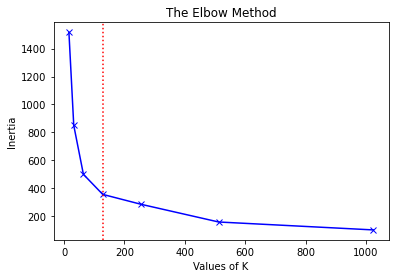

In [18]:
plt.plot(K,inertias,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.axvline(x=128,linestyle=':',color='r') #Can see at 128 is where the elbow is
plt.show()

#Point of the elbow is the most optimal value for choosing k 

In [19]:
kmeans = MiniBatchKMeans(128)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

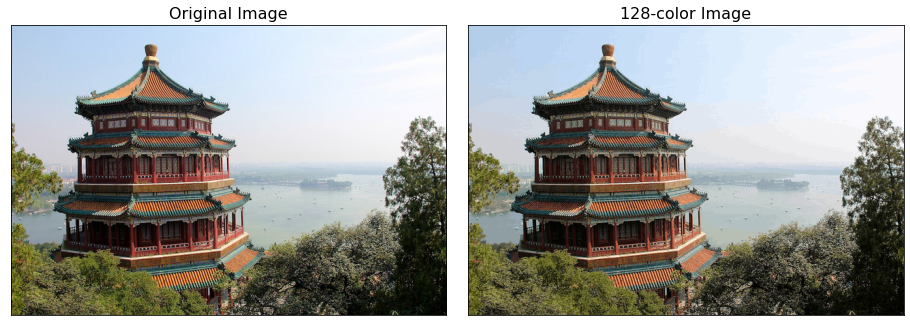

In [21]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('128-color Image', size=16);

### Interpretation:
* This question was quite a hurdle. To start off with, the get the optimal value for K, I opted to use the Elbow method. The Elbow method plots the various values with changing K and as K increases there are fewer elements in the cluster. Thus decreasing the average distortion. To determine the optimal number of clusters, we select the value of K at the elbow, or the point after the distortion/inertia start decreasing in a linear way. 

* To get a better understanding, Inertia is the sum of the squared distances of samples to their closest cluster center and Distortion is calculated average of the squared distances from the cluster centers of the respective clusters (typically the Euclidean distance metric is used)

* That being said, the Elbow method returns 128 as the optimal value for K. Furthermore, the algorithm that I opted for in this code was the MiniBatchKMeans due to the fact that the KMeans algorithm would crash my computer since we are dealing with a lot of datapoints or pixels. 

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [188]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.metrics import precision_score,recall_score,accuracy_score,fowlkes_mallows_score,confusion_matrix,classification_report

In [193]:
df = pd.read_csv('data/college.csv')
#df.head()
df['Private'] = df.Private.replace(['Yes','No'],[1,0])

In [200]:
#Normalizer()

N_CLUSTER = 2

X = df.drop(['Private','Unnamed: 0'],axis=1)
y = df.Private

scale = Normalizer()
X = scale.fit_transform(X)

In [201]:
kmeans = KMeans(n_clusters=N_CLUSTER,random_state=675)
kmeans.fit(X)

pred = kmeans.predict(X) #kmeans.labels_? also works. I think

In [202]:
print('Accuracy Score: {0}'.format(np.round(accuracy_score(y, pred),4)))
print('\nPrecision Score: {0}'.format(np.round(precision_score(y,pred),4)))
print('\nRecall Score: {0}'.format(np.round(recall_score(y,pred),4)))
print('\nFMI: {0}'.format(np.round(fowlkes_mallows_score(y,pred),4)))
print('\nConfusion Matrix: \n{0}'.format(confusion_matrix(y,pred)))
print('\nClassification Report:\n{0}'.format(classification_report(y,pred)))

#Believe FMI takes the average precision and average recall score for each and then multiplies those values and 
# takes square root.

Accuracy Score: 0.0952

Precision Score: 0.0988

Recall Score: 0.0301

FMI: 0.8635

Confusion Matrix: 
[[ 57 155]
 [548  17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.27      0.14       212
           1       0.10      0.03      0.05       565

    accuracy                           0.10       777
   macro avg       0.10      0.15      0.09       777
weighted avg       0.10      0.10      0.07       777



### Evaluation:

Honestly at first it seemed that this model was not ideal because the accuracy score goes back and forth from 90% accuracy to less than 10% accuracy. One thing to note is that even if the True and False Positives and Negatives switch places, the FMI stays at a comfortable .8635 which would make sence since it is an evaluation metric to evaluate the similarity among clusterings obtained after applying the clustering algorithm and not an evaluation as to how much of the data was classified accurately. This is a good example as to why FMI is an important metric in this scenario and that accuracy score can be misleading. Also since the program doesn't know if 0 is Yes or No, that is what causes the scores to flutuate and to fix this we can use the statistical mode as we have done in the first question which returns the same scores each time

In [203]:
#Makes sure that the values don't change

from statistics import mode

pred = kmeans.predict(X)

label = np.zeros_like(pred) #Same shape as pred

for i in range(0,2):
    label[pred==i] = mode(df.Private[pred==i])

In [204]:
print('Accuracy Score: {0}'.format(np.round(accuracy_score(y, label),4)))
print('\nPrecision Score: {0}'.format(np.round(precision_score(y,label),4)))
print('\nRecall Score: {0}'.format(np.round(recall_score(y,label),4)))
print('\nFMI: {0}'.format(np.round(fowlkes_mallows_score(y,label),4)))
print('\nConfusion Matrix: \n{0}'.format(confusion_matrix(y,label)))
print('\nClassification Report:\n{0}'.format(classification_report(y,label)))

Accuracy Score: 0.9048

Precision Score: 0.9058

Recall Score: 0.9699

FMI: 0.8635

Confusion Matrix: 
[[155  57]
 [ 17 548]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       212
           1       0.91      0.97      0.94       565

    accuracy                           0.90       777
   macro avg       0.90      0.85      0.87       777
weighted avg       0.90      0.90      0.90       777



In [215]:
#2
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues...
from sklearn.cluster import MiniBatchKMeans

n_clusters = [2, 3, 4, 5, 6, 8, 10]

for c in n_clusters:
    k_model = KMeans(n_clusters=c).fit(X)
    pred = k_model.predict(X)
    print('N_Clusters: {0}, FMI: {1}'.format(c,np.round(fowlkes_mallows_score(y,pred),5)))

N_Clusters: 2, FMI: 0.86352
N_Clusters: 3, FMI: 0.79253
N_Clusters: 4, FMI: 0.71452
N_Clusters: 5, FMI: 0.66354
N_Clusters: 6, FMI: 0.55765
N_Clusters: 8, FMI: 0.4749
N_Clusters: 10, FMI: 0.42853


For n_clusters = 2 The average silhouette_score is : 0.585803103928166
For n_clusters = 3 The average silhouette_score is : 0.405879433087357
For n_clusters = 4 The average silhouette_score is : 0.3351384087651876
For n_clusters = 5 The average silhouette_score is : 0.3071217207300303
For n_clusters = 6 The average silhouette_score is : 0.22154358092806095


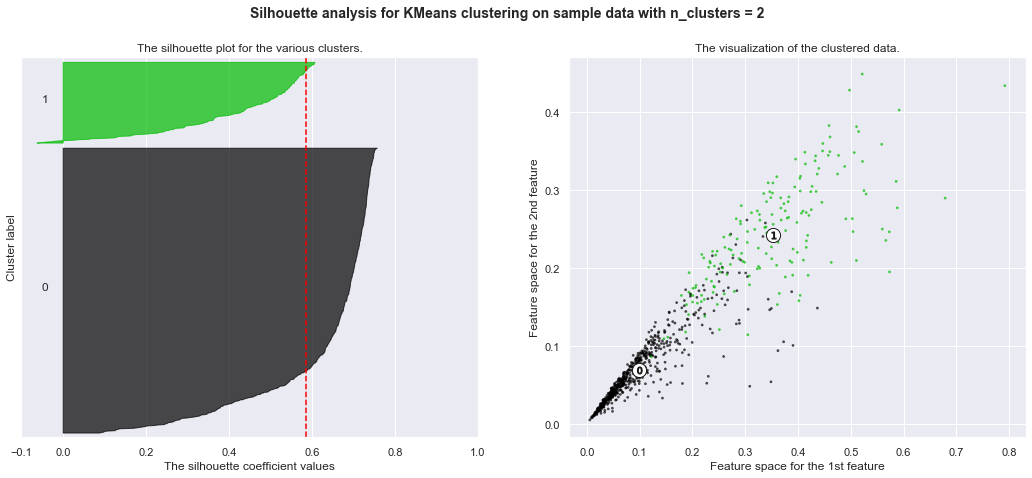

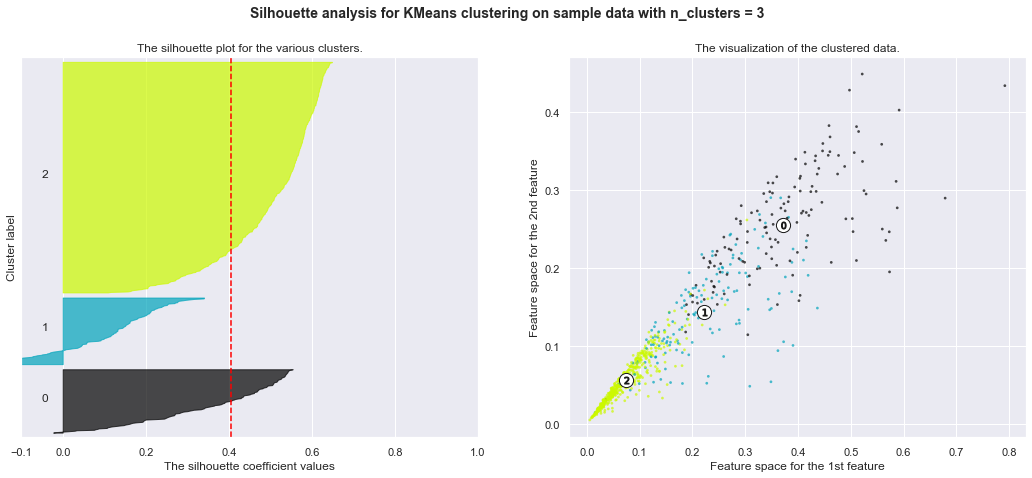

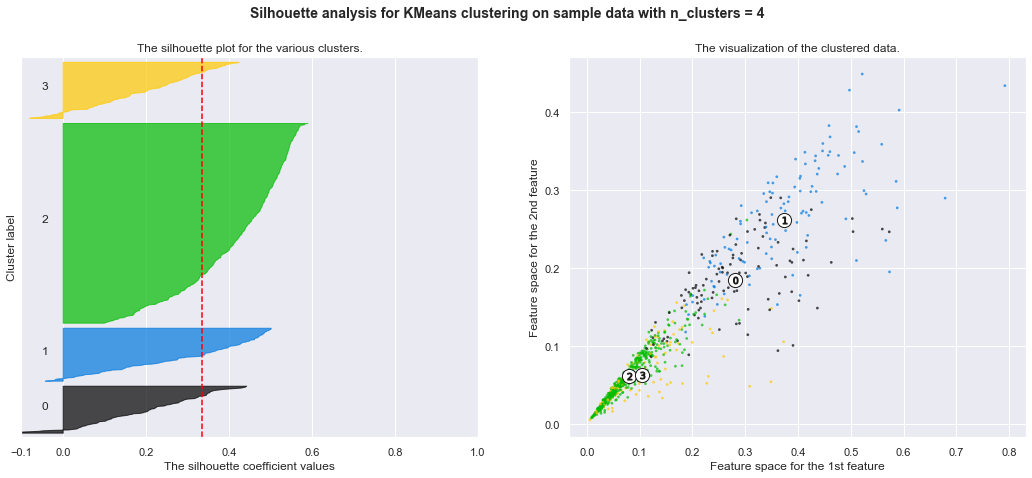

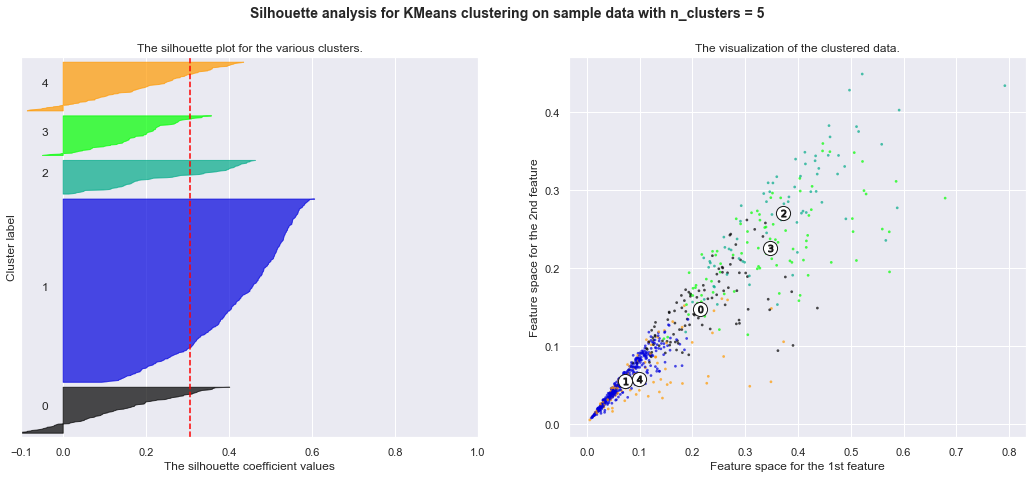

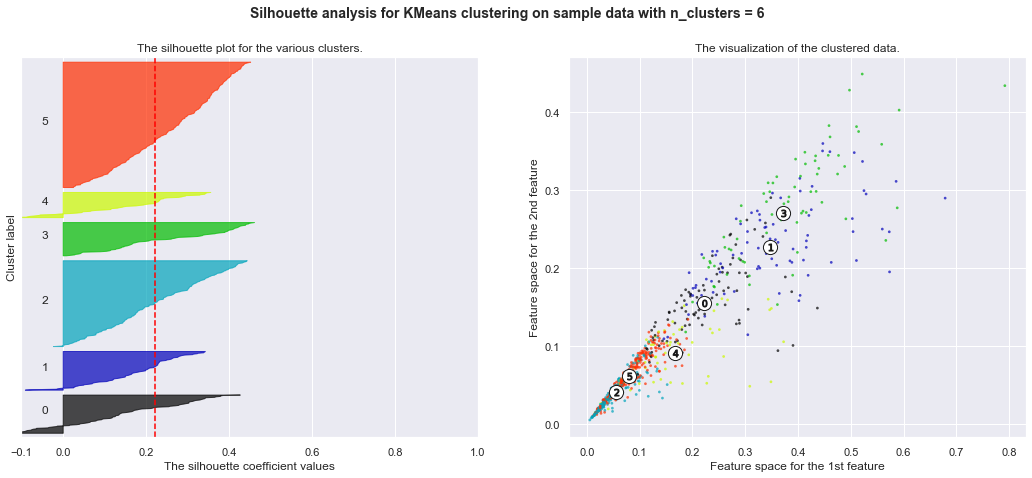

In [205]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Reasoning:

* The optimal value for k is 2. The first way I found this out was by looping through various k values and get the FMI for that specific number of clusters. The best that was returned was a k of 2 with and FMI of .86. The second way was with the abov code and teh silhouette score. There again, k with a value was returned as being the the optimal value. This would resonate well with the fact that we are dealing with binary data. Either a yes or a no, so having more than two clusters would negatively impact the model.